In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold
import math
import csv

#The model
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter("ignore")

In [2]:
class AnomalyDetectionDataLoader:

    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = RobustScaler()

    def load_data_creditcard(self):
        # Charger les données depuis le fichier CSV
        self.data = pd.read_csv(self.file_path)

        # Supprimer les duplicatas en conservant la dernière occurrence
        self.data.drop_duplicates(keep="last", inplace=True)

        # Extraire la variable cible et les caractéristiques
        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def load_data_backdoor(self):
        # Charger les données depuis le fichier CSV
        self.data = pd.read_csv(self.file_path)

        # Supprimer les duplicatas en conservant la dernière occurrence
        self.data.drop_duplicates(keep="last", inplace=True)

        # Extraire la variable cible et les caractéristiques
        self.target = self.data["Class"]
        self.data.drop(["Class","Time"], axis=1,inplace=True)

    def preprocess_data(self):
        # Normaliser les caractéristiques avec Min-Max Scaling
        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):
        # Diviser les données en ensembles d'entraînement et de test
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler

    def get_data(self):
      return self.data, self.target



In [3]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

In [4]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores_(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
def draw_anomaly(y_true,score, seuil):
    groupDF=pd.DataFrame({
        "error":score,
        "true":y_true
    }).groupby('true')
    fig, ax=plt.subplots(figsize=(12,8))

    for name, group in groupDF:
        ax.plot(group.index,group.error,marker='x', linestyle='',color='r' if name==1 else 'g',label="anomalie" if name==1 else "normal")
    ax.hlines(seuil,ax.get_xlim()[0],ax.get_xlim()[1], colors ="b", zorder=100,label="Seuil")
    ax.legend()
    
    plt.title("Anomalies")
    plt.xlabel("Données")
    plt.ylabel("Score(erreur)")
    plt.show()
    
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    # precision_recall_display(ytrue, ypred)
    # roc_curve_disolay(ytrue, ypred)
    scores_(ytrue,ypred)

In [5]:
class CustomGridSearchCV:

    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):


        param_grid = ParameterGrid(self.param_grid)
        # skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)

        for params in tqdm(param_grid):


            total_score = 0

            # Itérer sur les plis de la validation croisée
            # for train_index, val_index in tqdm(skf.split(X,y)):
            # xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
            # ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

            # Entraîner le modèle
            model = self.estimator.set_params(**params)

            # Faire des prédictions
            ypred_val = model.fit_predict(X)
            ypred_val = inverse_transform_target(ypred_val)

            avg_score = f1_score(ypred_val, y)

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,X):
        return self.best_estimator.fit_predict(X)

In [6]:
# Utilisation de la classe
file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
# file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv"
data_loader = AnomalyDetectionDataLoader(file_path=file_path)
data_loader.load_data_creditcard()
# data_loader.preprocess_data()

X, y = data_loader.get_data()
scaler = data_loader.get_scaler()

In [7]:
best_par={
           'contamination': [0.0012, 0.0015,0.0017, 0.0019, 0.0021, 0.0023],
           'n_neighbors': [180,200, 250, 300, 350,400,450,500, 550, 600, 650,700,750, 800,850,900,950,1000]
}
model=CustomGridSearchCV(estimator=LocalOutlierFactor(), param_grid=best_par, n_splits=5, random_state=42)
model.fit(X,y)

  0%|          | 0/108 [00:00<?, ?it/s]

Paramètres: {'contamination': 0.0012, 'n_neighbors': 180}
Score moyen (f1_score): 0.21375921375921375
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 200}
Score moyen (f1_score): 0.22113022113022113
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 250}
Score moyen (f1_score): 0.24324324324324326
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 300}
Score moyen (f1_score): 0.2800982800982801
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 350}
Score moyen (f1_score): 0.32432432432432434
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 400}
Score moyen (f1_score): 0.3538083538083538
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 450}
Score moyen (f1_score): 0.3636363636363636
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 500}
Score moyen (f1_score): 0.3808353808353808
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 550}
Score moyen (f1_score): 0.38574938574938566
 
Paramètres: {'contamination': 0.0012, 'n_neighbors': 600}
Score moye

In [19]:
print(model.best_params)

{'contamination': 0.0023, 'n_neighbors': 450}


In [20]:
# model.best_params
params=model.best_params

In [21]:
lof=LocalOutlierFactor(**params)

In [22]:
ypred=lof.fit_predict(X)

In [23]:
ypred=inverse_transform_target(ypred)

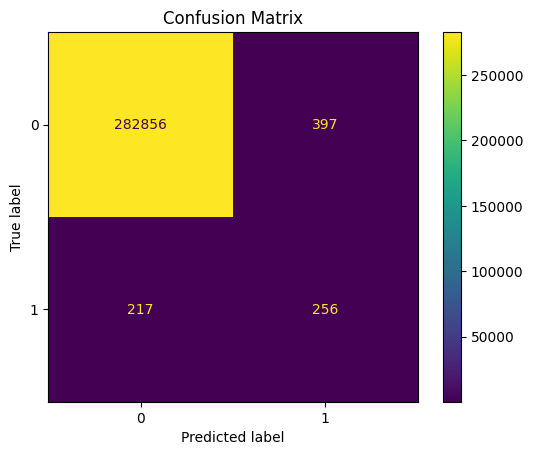

   f1_score  accuracy_score  precision_score  recall_score
0  0.454707        0.997836         0.392037      0.541226


In [24]:
evaluation(y,ypred)

### Histogramme de scores d'anomalies

In [25]:
score=-lof.negative_outlier_factor_
score_pd=pd.Series(score)

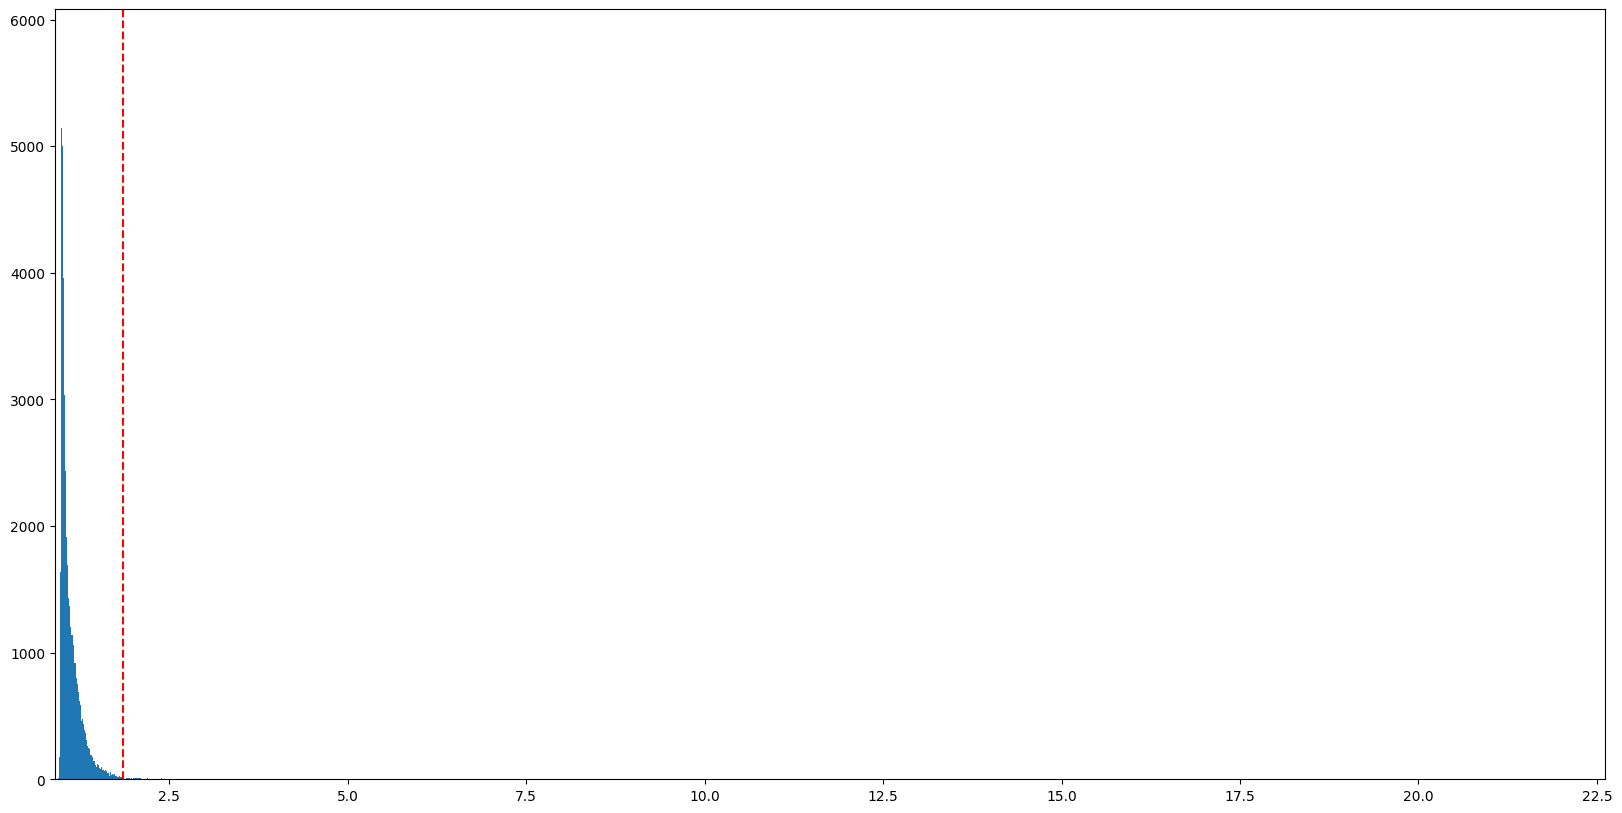

In [39]:
ffig,ax=plt.subplots(figsize=(20,10))
plt.xlim(min(score)-0.05, max(score_pd))
score_pd.hist(bins=10000,grid=False)

# Détermination de pourcentage de contamination
q=99
p=1
plt.axvline(np.percentile(score_pd, q=q), color='red', linestyle='--', label=f'{q}e percentile')


plt.show()

### Boite à moustache des scores d'anomalies

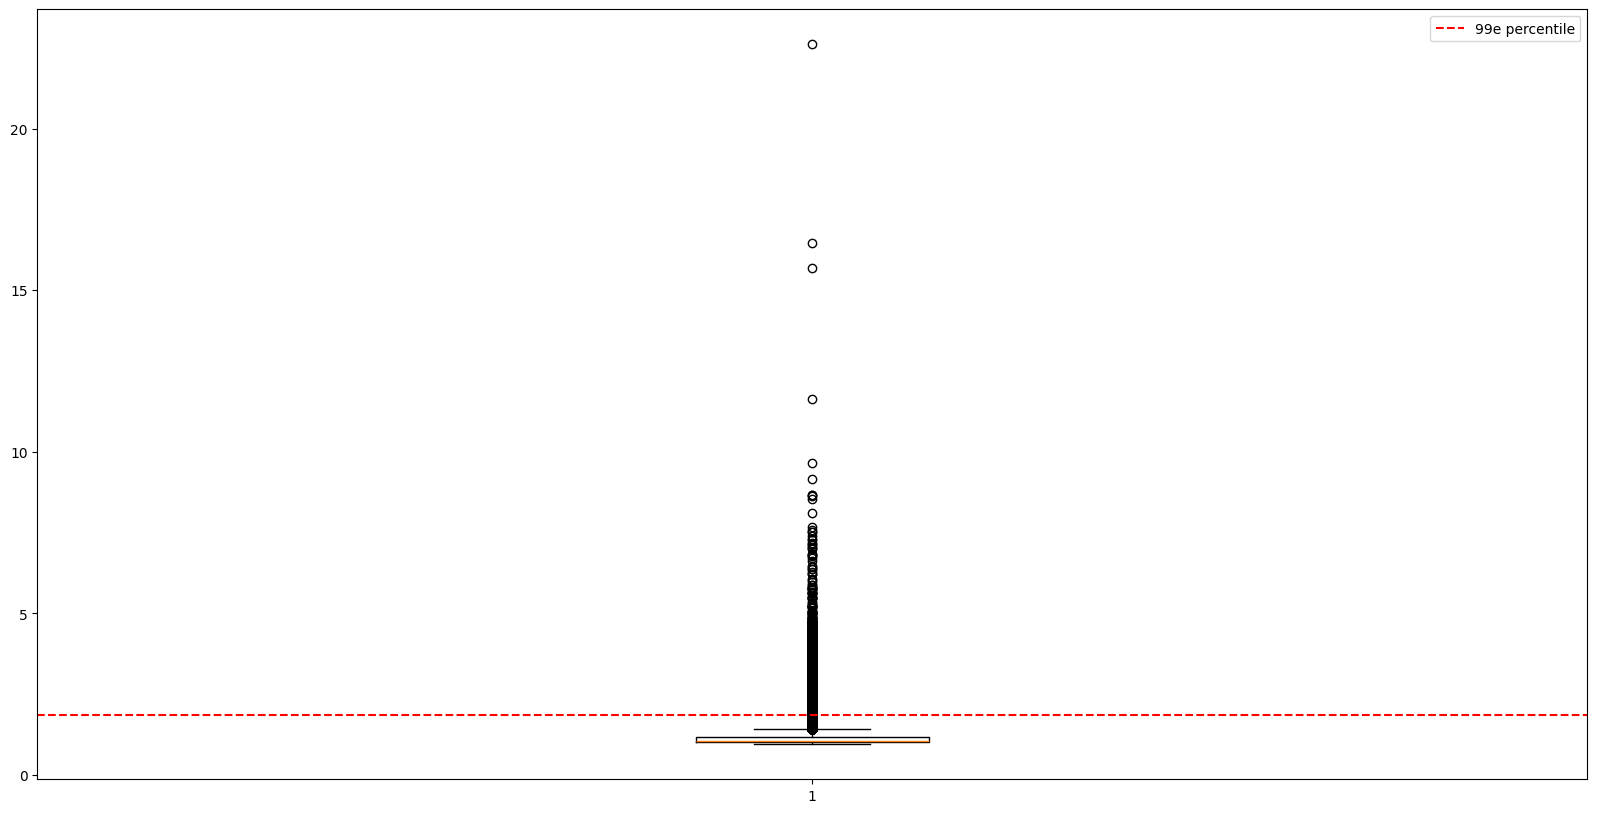

1.5524963716916915
1.8575563045738201


In [42]:
fig,ax=plt.subplots(figsize=(20,10))
# plt.xlim(min(score)-0.2, max(score))
plt.boxplot(score_pd)

# Détermination de pourcentage de contamination
q=99
p=1
plt.axhline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')

plt.legend()

plt.show()
print(np.percentile(score, q=97))
print(np.percentile(score, q=99))

### Visualisation des anomalies

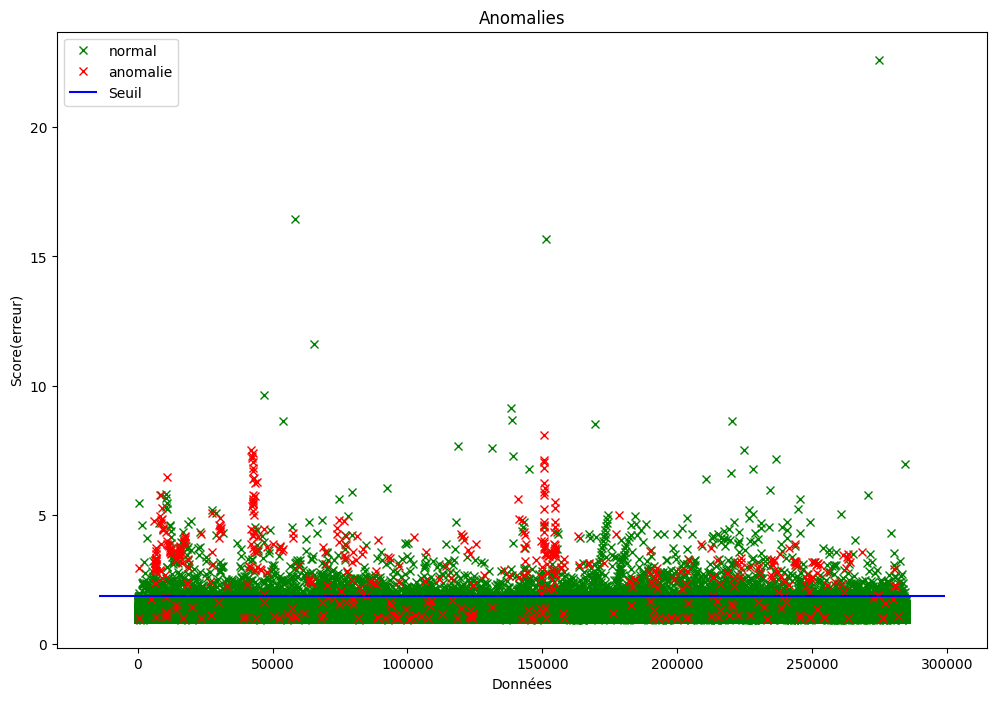

1.8575563045738201

In [36]:
draw_anomaly(y_true=y,score=score, seuil=np.percentile(score, q=99))
np.percentile(score, q=99)

### Sauvegarde des résulatats

In [43]:
file_name="../resultats/lof.csv"

with open(file_name,"w",newline="") as csvfile:
    writer=csv.DictWriter(csvfile,fieldnames=["y_pred","score_anomalie","y_true"])
    writer.writeheader()
    n=score.shape[0]
    for i in range(n):
        row={
            "y_pred":ypred[i],
            "score_anomalie":score[i],
            "y_true":X.iloc[i],
        }
        writer.writerow(row)

### Courbes ROC-AUC

LOF: ROC AUC=0.911


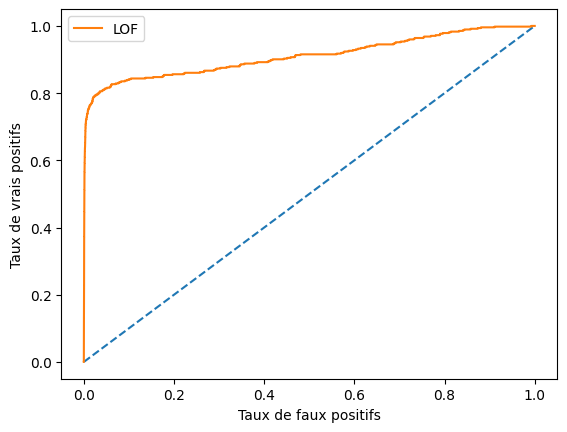

In [44]:
import torch 
ns_probs = [0 for _ in range(len(y))]
# keep probabilities for the positive outcome only
np_score = score.tolist()
tensor=torch.tensor([np_score])
lr_probs = torch.softmax(tensor,dim=1,dtype=torch.float32).squeeze(0).numpy()
# lr_probs =-model.decision_function(X)

# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)
# summarize scores

print('LOF: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='LOF')
# axis labels
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Serialize the object to a file
import pickle
with open("./Lof_creditcard.pickle", "wb") as file:
    pickle.dump(cl, file)

TSNE visualisation

In [ ]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv'

In [ ]:
viz_y = cl.fit_predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [ ]:
with open(src_path + "/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open(src_path + "/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Local Outlier Factor')

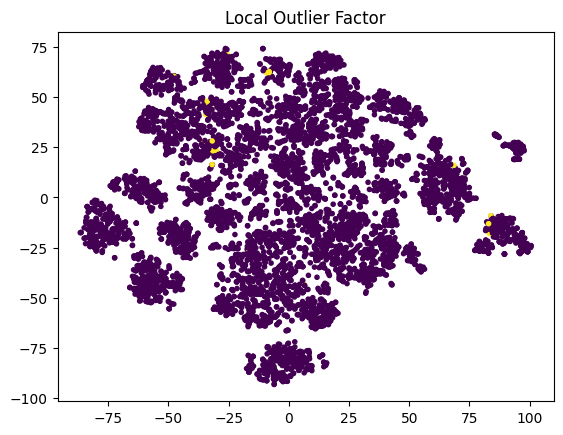

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Local Outlier Factor")

BACKDOOR

In [ ]:
# Utilisation de la classe
# file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv"
data_loader = AnomalyDetectionDataLoader(file_path=file_path)
data_loader.load_data_backdoor()
data_loader.preprocess_data()

x, y = data_loader.get_data()
scaler = data_loader.get_scaler()

In [ ]:
best_par={
           'contamination': [0.003],
           'n_neighbors': [10, 20, 50, 100, 120,150,160]
}
model=CustomGridSearchCV(estimator=LocalOutlierFactor(), param_grid=best_par, n_splits=5, random_state=42)
model.fit(x,y)

  0%|          | 0/7 [00:00<?, ?it/s]

Paramètres: {'contamination': 0.003, 'n_neighbors': 10}
Score moyen (f1_score): 0.14946286781877627
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 20}
Score moyen (f1_score): 0.1335824381130313
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 50}
Score moyen (f1_score): 0.1588042970574498
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 100}
Score moyen (f1_score): 0.15226529659037832
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 120}
Score moyen (f1_score): 0.15693601120971507
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 150}
Score moyen (f1_score): 0.1588042970574498
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 160}
Score moyen (f1_score): 0.1588042970574498
 
Meilleurs paramètres : {'contamination': 0.003, 'n_neighbors': 50}
Meilleur score moyen (f1_score) : 0.1588042970574498


In [ ]:
print(model.best_params)

{'contamination': 0.003, 'n_neighbors': 50}


In [ ]:
# model.best_params
params=model.best_params

In [ ]:
cl_backdoor=LocalOutlierFactor(**params)

In [ ]:
ypred=cl_backdoor.fit_predict(x)

In [ ]:
ypred=inverse_transform_target(ypred)

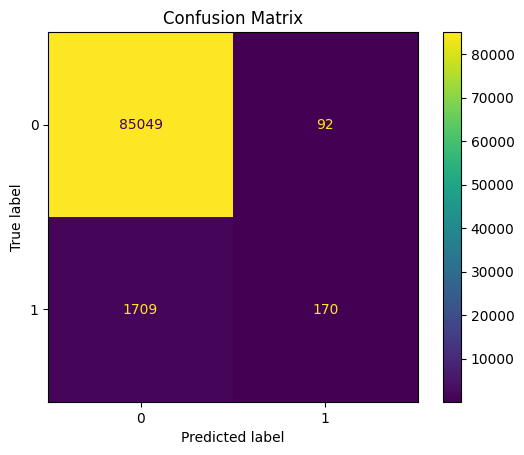

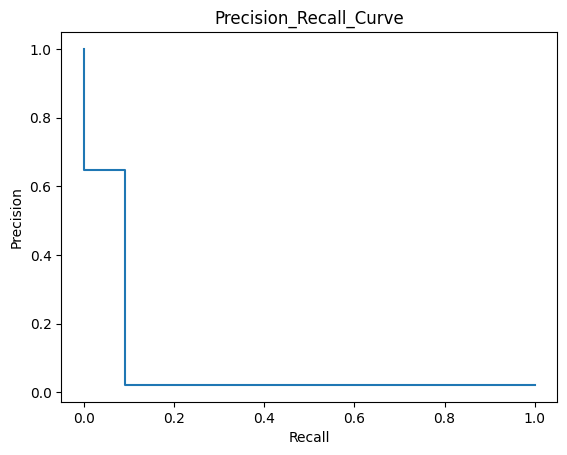

roc_auc 0.5446965478590412


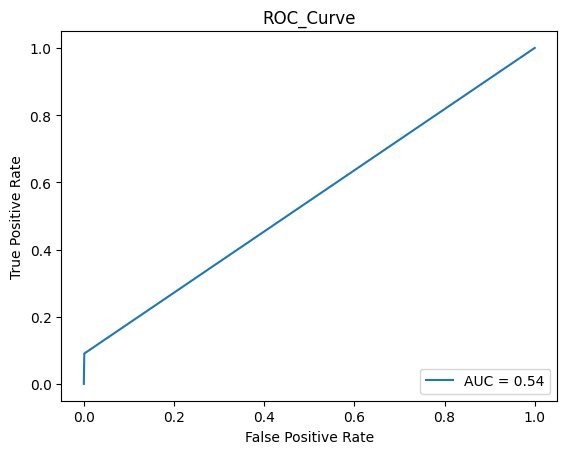

   f1_score  accuracy_score  precision_score  recall_score
0  0.158804        0.979304         0.648855      0.090474


In [ ]:
evaluation(y, ypred)

In [ ]:
score=model.score_samples(xtest)
score_pd=pd.Series(score)

In [ ]:
# Serialize the object to a file
import pickle
with open("./Lof_backdoor.pickle", "wb") as file:
    pickle.dump(cl_backdoor, file)

TSNE visualisation backdoor

In [ ]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['class'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [ ]:
viz_y = cl_backdoor.fit_predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [ ]:
with open(src_path + "/X_embedded_backdoor.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open(src_path + "/embedded_index_backdoor.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Local Outlier Factor')

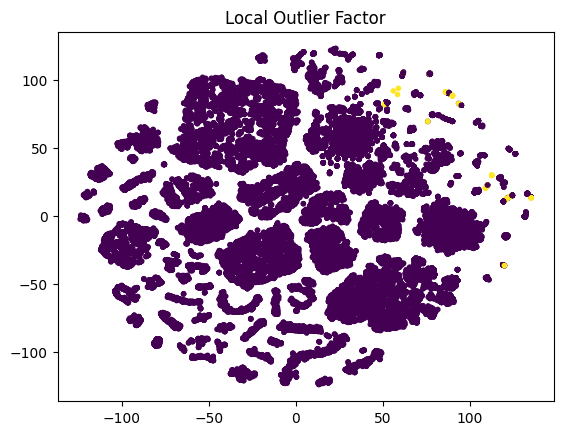

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Local Outlier Factor")